In [238]:
import csv
import numpy as np
import emoji
import pandas as pd
import math

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


def read_csv(filename = 'emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y


emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              
    
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(i)
        print(X[i], label_to_emoji(int(pred[i])))

# 1. Prepare training/test dataset & word embedding

1. glove.6B.50d.txt
2. glove.6B.100d.txt

In [2]:
x_train, y_train = read_csv("train_emoji.csv")
x_test, y_test = read_csv("test_emoji.csv")

In [3]:
import gzip
import zipfile

zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [4]:
embedding_dict_50d = dict()

f = open('glove.6B.50d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict_50d[word] = word_vector_arr
f.close()

In [5]:
embedding_dict_100d = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict_100d[word] = word_vector_arr
f.close()

In [6]:
def word_embedding_inner(list_input,d_n=50):
    if d_n == 50:
        return np.array([embedding_dict_50d[str(x).lower()] for x in list_input])
    if d_n == 100:
        return np.array([embedding_dict_100d[str(x).lower()] for x in list_input])

In [7]:
def word_embedding(list_input,d_n=50):
    list_input_array = [x.split() for x in list_input]
    if d_n == 50:
        return [word_embedding_inner(x,50) for x in list_input_array]
    if d_n == 100:
        return [word_embedding_inner(x,100) for x in list_input_array]

In [8]:
def y_array_inner(input_value):
    k = np.zeros(5).reshape(5,1)
    k[input_value][0] = 1
    return k

In [9]:
def y_array(list_input):
    return [y_array_inner(x) for x in list_input]

# 2. Design Recurrent Neural Network (using only python)

1. Design RNN (Vanilla RNN and LSTM)
2. Design output layer with Cross-Entropy loss
3. Design Dropout

In [10]:
def Vanila_RNN(h_t1 ,x_t, W_xh, W_hh, b_h ):
    h_t = np.tanh(np.dot(W_xh,x_t).reshape(128,1) + np.dot(W_hh,h_t1) + b_h) # W_xh (128,50 or 100) # bias (128,1) #W_hh (128,128)
    return h_t #(128,1)


def Soft_Max(z):
    c = np.max(z)
    exp_z = np.exp(z-c)
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y

def Cross_entrophy_loss(y_label, y_prediction):
    return -np.sum(y_label*np.log(y_prediction+1e-7))

def FC_layer(input_layer,Weight,bias): #weight(5,128) # bias(5,1) #dense = FC
    return np.dot(input_layer,Weight) + bias # output (5,1)

def dropout(layer,prob):
    if prob == 1:
        return np.zeros_like(X)
    mask = np.random.uniform(0, 1, layer.shape) > prob
    mask = np.random.uniform(0, 1, layer.shape) > prob
    return [ mask.astype(np.float32)*layer / (1.0 - prob) , mask*np.ones(layer.shape)/(1.0 - prob) ]

def Cross_entrophy_loss(y_label, y_prediction):
    return -np.sum(y_label*np.log(y_prediction+1e-7))

def sigmoid(x):
    return 1 / (1 +np.exp(-x))

# 3. Implement whole training & test pipeline with optimizer

1. Design optimizer (SGD and ADAM)
2. Training procedure

# Vanilla RNN

In [11]:
def foward_propagation(inputs, y_label, W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC, drop_prob):
    k = len(inputs)
    a_layer_1 = [np.zeros((128,1))]
    a_layer_dropout = []
    a_layer_dropout_d = []
    a_layer_2 = [np.zeros((128,1))]
    
    #foward pass
    for i in range(0, 1):
        #RNN1
        a_layer_1.append(Vanila_RNN(a_layer_1[i] ,inputs[i], W_xh_1, W_hh_1, b_h_1))
        a_layer_dropout.append(dropout(a_layer_1[i+1],drop_prob)[0])
        a_layer_dropout_d.append(dropout(a_layer_1[i+1],drop_prob)[1])
        #RNN2
        a_layer_2.append(Vanila_RNN(a_layer_2[i] ,a_layer_dropout[i], W_xh_2, W_hh_2, b_h_2))

    #FC layer
    d_2,d_2_z  = dropout(a_layer_2[-1], drop_prob)
    z = np.dot(W_FC,d_2)+bias_FC
    y_prediction = Soft_Max(z)

    #loss
    loss = Cross_entrophy_loss(y_label,y_prediction)
    return a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, z, y_prediction, loss

In [12]:
def backward_propagation(y_label,y_prediction, a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, embedding_type,inputs,W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC):
    #FC layer
    d_FC = -(y_label - y_prediction) #(5,1)
    d_FC_b = np.dot(d_FC,d_2.T) # (5,128)
    
    #BTT W_hh_2 (128,1) W_hh_2_b (128,128) , W_xh_2 (128,128)
    d_W_hh_2 = np.zeros((128,1))
    d_W_hh_2_b = np.zeros((128,128))
    d_W_xh_2_b = np.zeros((128,128))
    
    d_W_hh_1 = np.zeros((128,1))
    d_W_hh_1_b = np.zeros((128,128))
    d_W_xh_1_b = np.zeros((128,embedding_type)) #type

    d_W_hh_2_prev = np.dot(W_FC.T,d_FC)*d_2_z*(1-(a_layer_2[-1])**2) # 128,1
    d_W_hh_2_b_prev = np.dot(d_W_hh_2_prev,a_layer_2[-2].T) # 128. 128
    d_W_xh_2_b_prev = np.dot(d_W_hh_2_prev,a_layer_dropout[-1].T) #128, 128
    
    d_W_hh_2 += d_W_hh_2_prev
    d_W_hh_2_b += d_W_hh_2_b_prev
    d_W_xh_2_b += d_W_xh_2_b_prev
    
    for i in range(len(a_layer_2)-2,0,-1):
        d_W_hh_1_prev = np.dot(W_xh_2.T,d_W_hh_2_prev)*a_layer_dropout_d[i]*(1-(a_layer_1[i+1])**2)
        for j in range(i,-1,-1):
            d_W_hh_1_b_prev = np.dot(d_W_hh_1_prev,a_layer_1[j].T)
            d_W_xh_1_b_prev = np.dot(d_W_hh_1_prev,inputs[j].reshape(1,50))
            
            d_W_hh_1 += d_W_hh_1_prev
            d_W_hh_1 += d_W_hh_1_prev
            d_W_xh_1_b += d_W_xh_1_b_prev
            
            d_W_hh_1_prev = np.dot(W_hh_1.T,d_W_hh_1_prev)*(1-(a_layer_1[j]**2))
        
        d_W_xh_1_b += d_W_xh_1_b_prev
        d_W_hh_2_prev = np.dot(W_hh_2.T,d_W_hh_2_prev)*(1-a_layer_2[i]**2) #(128,1)
        d_W_hh_2_b_prev = np.dot(d_W_hh_2_prev,a_layer_2[i-1].T)
        d_W_xh_2_b_prev = np.dot(d_W_hh_2_prev,a_layer_dropout[i-1].T)

        d_W_hh_2 += d_W_hh_2_prev
        d_W_hh_2_b += d_W_hh_2_b_prev
        d_W_xh_2_b += d_W_xh_2_b_prev
    return d_FC, d_FC_b, d_W_hh_2, d_W_hh_2_b, d_W_xh_2_b, d_W_hh_1, d_W_hh_1_b, d_W_xh_1_b

In [218]:
def RNN(input_data_x,input_data_y,Optimizer="SGD",Model="VG",batchsize=8,epoch=10,embedding_type = 50):
    data_nums = len(input_data_x)
    iteration = math.floor(data_nums/batchsize)
    
    #initialziation
    W_xh_1 = np.random.random((128,embedding_type))*0.01
    W_hh_1 = np.random.random((128,128))*0.01
    b_h_1 = np.random.random((128,1))*0.01
    W_xh_2 = np.random.random((128,128))*0.01
    W_hh_2 = np.random.random((128,128))*0.01
    b_h_2 = np.random.random((128,1))*0.01
    W_FC = np.random.random((5,128))*0.01
    bias_FC = np.random.random((5,1))*0.01
    drop_prob = 0
    learning_rate = batchsize/132
    loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    test_label_list = []
    #adam 영역
    beta_1 = 0.9
    beta_2 = 0.999
    theta = 10**(-16)
    t = 0
    
    m_t_prev_dd_W_xh_1_b = np.zeros_like(W_xh_1)
    m_t_prev_dd_W_hh_1_b = np.zeros_like(W_hh_1)
    m_t_prev_dd_W_hh_1 = np.zeros_like(b_h_1)
                
    m_t_prev_dd_W_xh_2_b = np.zeros_like(W_xh_2)
    m_t_prev_dd_W_hh_2_b = np.zeros_like(W_hh_2)
    m_t_prev_dd_W_hh_2 = np.zeros_like(b_h_2)
                    
    m_t_prev_dd_FC_b = np.zeros_like(W_FC)
    m_t_prev_bdd_FC = np.zeros_like(bias_FC)
    
    v_t_prev_dd_W_xh_1_b = np.zeros_like(W_xh_1)
    v_t_prev_dd_W_hh_1_b = np.zeros_like(W_hh_1)
    v_t_prev_dd_W_hh_1 = np.zeros_like(b_h_1)
                
    v_t_prev_dd_W_xh_2_b = np.zeros_like(W_xh_2)
    v_t_prev_dd_W_hh_2_b = np.zeros_like(W_hh_2)
    v_t_prev_dd_W_hh_2 = np.zeros_like(b_h_2)
                    
    v_t_prev_dd_FC_b = np.zeros_like(W_FC)
    v_t_prev_bdd_FC = np.zeros_like(bias_FC)
    
    #Vanila RNN
    if Model == "VG":
        for i in range(0,epoch):
            loss_all = 0
            error = 0
            dd_FC = np.zeros((5,1))
            dd_FC_b = np.zeros((5,128))
            dd_W_hh_2 = np.zeros((128,1))
            dd_W_hh_2_b = np.zeros((128,128))
            dd_W_xh_2_b = np.zeros((128,128))
            
            dd_W_hh_1 = np.zeros((128,1))
            dd_W_hh_1_b = np.zeros((128,128))
            dd_W_xh_1_b = np.zeros((128,embedding_type)) #type
            
            t = 0
            m_t_prev_dd_W_xh_1_b = np.zeros_like(W_xh_1)
            m_t_prev_dd_W_hh_1_b = np.zeros_like(W_hh_1)
            m_t_prev_dd_W_hh_1 = np.zeros_like(b_h_1)
                
            m_t_prev_dd_W_xh_2_b = np.zeros_like(W_xh_2)
            m_t_prev_dd_W_hh_2_b = np.zeros_like(W_hh_2)
            m_t_prev_dd_W_hh_2 = np.zeros_like(b_h_2)
                    
            m_t_prev_dd_FC_b = np.zeros_like(W_FC)
            m_t_prev_bdd_FC = np.zeros_like(bias_FC)
    
            v_t_prev_dd_W_xh_1_b = np.zeros_like(W_xh_1)
            v_t_prev_dd_W_hh_1_b = np.zeros_like(W_hh_1)
            v_t_prev_dd_W_hh_1 = np.zeros_like(b_h_1)
                
            v_t_prev_dd_W_xh_2_b = np.zeros_like(W_xh_2)
            v_t_prev_dd_W_hh_2_b = np.zeros_like(W_hh_2)
            v_t_prev_dd_W_hh_2 = np.zeros_like(b_h_2)
                    
            v_t_prev_dd_FC_b = np.zeros_like(W_FC)
            v_t_prev_bdd_FC = np.zeros_like(bias_FC)


            for j in range(0,iteration):
                dd_FC = np.zeros((5,1))
                dd_FC_b = np.zeros((5,128))
                dd_W_hh_2 = np.zeros((128,1))
                dd_W_hh_2_b = np.zeros((128,128))
                dd_W_xh_2_b = np.zeros((128,128))
                dd_W_hh_1 = np.zeros((128,1))
                dd_W_hh_1_b = np.zeros((128,128))
                dd_W_xh_1_b = np.zeros((128,embedding_type)) #type
                
                for k in range(0,batchsize):
                    x_layer = input_data_x[j*batchsize+k]
                    y_layer = input_data_y[j*batchsize+k]
                    a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, z, y_prediction, loss = foward_propagation(x_layer, y_layer, W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC, drop_prob)
                    d_FC, d_FC_b, d_W_hh_2, d_W_hh_2_b, d_W_xh_2_b, d_W_hh_1, d_W_hh_1_b, d_W_xh_1_b =  backward_propagation(y_layer,y_prediction, a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, embedding_type,x_layer,W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC)
                    dd_FC += d_FC
                    dd_FC_b += d_FC_b
                    dd_W_hh_2 += d_W_hh_2
                    dd_W_hh_2_b += d_W_hh_2_b
                    dd_W_xh_2_b += d_W_xh_2_b
                    dd_W_hh_1 += d_W_hh_1
                    dd_W_hh_1_b += d_W_hh_1_b
                    dd_W_xh_1_b += d_W_xh_1_b
                    loss_all += loss
                    if np.argmax(y_prediction) != np.argmax(y_layer):
                        error += 1
                if Optimizer == "SGD":
                    
                    W_xh_1 -= dd_W_xh_1_b/132
                    W_hh_1 -= dd_W_hh_1_b/132
                    b_h_1 -= dd_W_hh_1/132
                    W_xh_2 -= dd_W_xh_2_b/132
                    W_hh_2 -= dd_W_hh_2_b/132
                    b_h_2 -= dd_W_hh_2/132
                    W_FC -= dd_FC_b/132
                    bias_FC -= dd_FC/132

                if Optimizer == "ADAM":
                    
                    t += 1
                    
                    m_t_prev_dd_W_xh_1_b = m_t_prev_dd_W_xh_1_b*beta_1 +(1-beta_1)*dd_W_xh_1_b
                    m_t_prev_dd_W_hh_1_b = m_t_prev_dd_W_hh_1_b*beta_1 +(1-beta_1)*dd_W_hh_1_b
                    m_t_prev_dd_W_hh_1 = m_t_prev_dd_W_hh_1*beta_1 +(1-beta_1)*dd_W_hh_1
                
                    m_t_prev_dd_W_xh_2_b = m_t_prev_dd_W_xh_2_b*beta_1 +(1-beta_1)*dd_W_xh_2_b
                    m_t_prev_dd_W_hh_2_b = m_t_prev_dd_W_hh_2_b*beta_1 +(1-beta_1)*dd_W_hh_2_b
                    m_t_prev_dd_W_hh_2 = m_t_prev_dd_W_hh_2*beta_1 +(1-beta_1)*dd_W_hh_2
                    
                    m_t_prev_dd_FC_b = m_t_prev_dd_FC_b*beta_1 +(1-beta_1)*dd_FC_b
                    m_t_prev_bdd_FC = m_t_prev_bdd_FC*beta_1 +(1-beta_1)*dd_FC
                    
                    v_t_prev_dd_W_xh_1_b = v_t_prev_dd_W_xh_1_b*beta_2 +(1-beta_2)*((dd_W_xh_1_b)**2)
                    v_t_prev_dd_W_hh_1_b = v_t_prev_dd_W_hh_1_b*beta_2 +(1-beta_2)*((dd_W_hh_1_b)**2)
                    v_t_prev_dd_W_hh_1 = v_t_prev_dd_W_hh_1*beta_2 +(1-beta_2)*((dd_W_hh_1)**2)
                
                    v_t_prev_dd_W_xh_2_b = v_t_prev_dd_W_xh_2_b*beta_2 +(1-beta_2)*((dd_W_xh_2_b)**2)
                    v_t_prev_dd_W_hh_2_b = v_t_prev_dd_W_hh_2_b*beta_2 +(1-beta_2)*((dd_W_hh_2_b)**2)
                    v_t_prev_dd_W_hh_2 = v_t_prev_dd_W_hh_2*beta_2 +(1-beta_2)*((dd_W_hh_2)**2)
                    
                    v_t_prev_dd_FC_b = v_t_prev_dd_FC_b*beta_2 +(1-beta_2)*((dd_FC_b)**2)
                    v_t_prev_bdd_FC = v_t_prev_bdd_FC*beta_2 +(1-beta_2)*((dd_FC)**2)
                    ##second unbias
                    s_m_t_prev_dd_W_xh_1_b = m_t_prev_dd_W_xh_1_b/(1-beta_1**t)
                    s_m_t_prev_dd_W_hh_1_b = m_t_prev_dd_W_hh_1_b/(1-beta_1**t)
                    s_m_t_prev_dd_W_hh_1 = m_t_prev_dd_W_hh_1/(1-beta_1**t)
                
                    s_m_t_prev_dd_W_xh_2_b = m_t_prev_dd_W_xh_2_b/(1-beta_1**t)
                    s_m_t_prev_dd_W_hh_2_b = m_t_prev_dd_W_hh_2_b/(1-beta_1**t)
                    s_m_t_prev_dd_W_hh_2 = m_t_prev_dd_W_hh_2/(1-beta_1**t)
                    
                    s_m_t_prev_dd_FC_b = m_t_prev_dd_FC_b/(1-beta_1**t)
                    s_m_t_prev_bdd_FC = m_t_prev_bdd_FC/(1-beta_1**t)
                    
                    s_v_t_prev_dd_W_xh_1_b = v_t_prev_dd_W_xh_1_b/(1-beta_2**t)
                    s_v_t_prev_dd_W_hh_1_b = v_t_prev_dd_W_hh_1_b/(1-beta_2**t)
                    s_v_t_prev_dd_W_hh_1 = v_t_prev_dd_W_hh_1/(1-beta_2**t)
                
                    s_v_t_prev_dd_W_xh_2_b = v_t_prev_dd_W_xh_2_b/(1-beta_2**t)
                    s_v_t_prev_dd_W_hh_2_b = v_t_prev_dd_W_hh_2_b/(1-beta_2**t)
                    s_v_t_prev_dd_W_hh_2 = v_t_prev_dd_W_hh_2/(1-beta_2**t)
                    
                    s_v_t_prev_dd_FC_b = v_t_prev_dd_FC_b/(1-beta_2**t)
                    s_v_t_prev_bdd_FC = v_t_prev_bdd_FC/(1-beta_2**t)
                    
                    W_xh_1 -= (1/(np.sqrt(s_v_t_prev_dd_W_xh_1_b)+theta))*(s_m_t_prev_dd_W_xh_1_b)/132
                    W_hh_1 -= (1/(np.sqrt(s_v_t_prev_dd_W_hh_1_b)+theta))*(s_m_t_prev_dd_W_hh_1_b)/132
                    b_h_1 -= (1/(np.sqrt(s_v_t_prev_dd_W_hh_1)+theta))*(s_m_t_prev_dd_W_hh_1)/132
                    W_xh_2 -= (1/(np.sqrt(s_v_t_prev_dd_W_xh_2_b)+theta))*(s_m_t_prev_dd_W_xh_2_b)/132
                    W_hh_2 -= (1/(np.sqrt(s_v_t_prev_dd_W_hh_2_b)+theta))*(s_m_t_prev_dd_W_hh_2_b)/132
                    b_h_2 -= (1/(np.sqrt(s_v_t_prev_dd_W_hh_2)+theta))*(s_m_t_prev_dd_W_hh_2)/132
                    W_FC -= (1/(np.sqrt(s_v_t_prev_dd_FC_b)+theta))*(s_m_t_prev_dd_FC_b)/132
                    bias_FC -= (1/(np.sqrt(s_v_t_prev_bdd_FC)+theta))*(s_m_t_prev_bdd_FC)/132
            loss_list.append(loss_all/132)
            train_accuracy_list.append(1-(error/132))
        
    #test Area
            test_loss = 0
            test_error = 0
            x_test_embedded_50 = word_embedding(x_test,50)
            x_test_embedded_100 = word_embedding(x_test,100)
            y_test_embedded = y_array(y_test)
            emoji = []
            if embedding_type == 50:
                for c in range(0,len(x_test_embedded_50)):
                    x_layer=x_test_embedded_50[c]
                    y_layer=y_test_embedded[c]
                    a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, z, y_prediction, loss = foward_propagation(x_layer, y_layer, W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC, drop_prob)
                    test_loss += loss/len(x_test_embedded_50)
                    emoji.append(y_prediction)
                    if np.argmax(y_layer) != np.argmax(y_prediction):
                        test_error += 1

            if embedding_type == 100:
                 for c in range(0,len(x_test_embedded_100)):
                    x_layer=x_test_embedded_100[c]
                    y_layer=y_test_embedded[c]
                    a_layer_1, a_layer_dropout, a_layer_dropout_d, a_layer_2, d_2, d_2_z, z, y_prediction, loss = foward_propagation(x_layer, y_layer, W_xh_1, W_hh_1, b_h_1, W_xh_2, W_hh_2, b_h_2, W_FC, bias_FC, drop_prob)
                    test_loss += loss/len(x_test_embedded_50)
                    emoji.append(y_prediction)
                    if np.argmax(y_layer) != np.argmax(y_prediction):
                        test_error += 1
            test_loss_list.append(test_loss)
            test_accuracy_list.append(1-(test_error/56))
            test_label_list.append(emoji)

    return loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, test_label_list

In [70]:
len(x_test_embedded_50)

56

# LSTM

In [14]:
def foward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,drop_prob):
    h_list_1 = []
    h_list_1.append(np.zeros((1,128)))

    c_list_1=[]
    i_list_1=[]
    o_list_1=[]
    f_list_1=[]
    g_list_1=[]
    c_list_1.append(np.zeros((1,128)))

    h_list_1_dropout = []
    h_list_1_dropout_derivative = []
    
    
    h_list_2 = []
    h_list_2.append(np.zeros((1,128)))
    c_list_2=[]
    i_list_2=[]
    o_list_2=[]
    f_list_2=[]
    g_list_2=[]
    c_list_2.append(np.zeros((1,128)))


    for i in range(0,len(x_layer)):
        #layer1
        #계산부분
        i_1 = sigmoid(np.dot(x_layer[i],wxi_1) + np.dot(h_list_1[i],whi_1) + biasi_1) #1,128
        f_1 = sigmoid(np.dot(x_layer[i],wxf_1) + np.dot(h_list_1[i],whf_1) + biasf_1)
        o_1 = sigmoid(np.dot(x_layer[i],wxo_1) + np.dot(h_list_1[i],who_1) + biaso_1)
        g_1 = np.tanh(np.dot(x_layer[i],wxg_1) + np.dot(h_list_1[i],whg_1) + biasg_1)
        
        c_1 = f_1*c_list_1[i] + i_1*g_1 #1,128
        h_1 = o_1*np.tanh(c_1) #1,128
        
        #list에 합치기
        i_list_1.append(i_1)
        o_list_1.append(o_1)
        f_list_1.append(f_1)
        g_list_1.append(g_1)
        c_list_1.append(c_1)
        h_list_1.append(h_1)
        
        h_list_1_dropout.append(dropout(h_1,drop_prob)[0])
        h_list_1_dropout_derivative.append(dropout(h_1,drop_prob)[1])
        
        #layer2
        #계산부분
        i_2 = sigmoid(np.dot(h_list_1_dropout[i],wxi_2) + np.dot(h_list_2[i],whi_2) + biasi_2) #1,128
        f_2 = sigmoid(np.dot(h_list_1_dropout[i],wxf_2) + np.dot(h_list_2[i],whf_2) + biasi_2)
        o_2 = sigmoid(np.dot(h_list_1_dropout[i],wxo_2) + np.dot(h_list_2[i],who_2) + biasi_2)
        g_2 = np.tanh(np.dot(h_list_1_dropout[i],wxg_2) + np.dot(h_list_2[i],whg_2) + biasi_2)
        
        c_2 = f_2*c_list_2[i] + i_2*g_2
        h_2 = o_2*np.tanh(c_2)
        
        #list에 합치기
        
        i_list_2.append(i_2)
        o_list_2.append(o_2)
        f_list_2.append(f_2)
        g_list_2.append(g_2)
        c_list_2.append(c_2)
        h_list_2.append(h_2)

    d_2 = dropout(h_list_2[-1],drop_prob)[0]
    d_2_derivative = dropout(h_list_2[-1],drop_prob)[1]
    
    y_prediction = Soft_Max(np.dot(d_2,W_FC) + bias_FC) #1,5
    
    #loss 계산
    loss = Cross_entrophy_loss(y_layer,y_prediction)
    return i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, loss 

In [15]:
def backward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, loss, embedding_type):
    #initialization
    dxg_2=np.zeros((128,128))
    dxi_2=np.zeros((128,128))
    dxf_2=np.zeros((128,128))
    dxo_2=np.zeros((128,128))
    
    dhg_2=np.zeros((128,128))
    dhi_2=np.zeros((128,128))
    dhf_2=np.zeros((128,128))
    dho_2=np.zeros((128,128))
    
    dbg_2=np.zeros((1,128))
    dbi_2=np.zeros((1,128))
    dbf_2=np.zeros((1,128))
    dbo_2=np.zeros((1,128))
    
    dxg_1=np.zeros((embedding_type,128))
    dxi_1=np.zeros((embedding_type,128))
    dxf_1=np.zeros((embedding_type,128))
    dxo_1=np.zeros((embedding_type,128))
    
    dhg_1=np.zeros((128,128))
    dhi_1=np.zeros((128,128))
    dhf_1=np.zeros((128,128))
    dho_1=np.zeros((128,128))
    
    dbg_1=np.zeros((1,128))
    dbi_1=np.zeros((1,128))
    dbf_1=np.zeros((1,128))
    dbo_1=np.zeros((1,128))
    
    #FC layer
    d_FC_raw = -(y_layer - y_prediction) #(1,5)
    d_FC_b = np.dot(d_2.T,d_FC_raw) # 

    dHt_2_prev = np.dot(d_FC_raw,W_FC.T)*d_2_derivative #1,128
    dCt_2_prev = (1-np.tanh(c_list_2[-1])*np.tanh(c_list_2[-1]))*dHt_2_prev*o_list_2[-1] #1,128

    #layer_2
    for i in range(-1,-len(c_list_2)+1,-1):
        dO_2 = dHt_2_prev*np.tanh(c_list_2[i])
        dF_2 = dCt_2_prev*c_list_2[i-1]
        dG_2 = dCt_2_prev*i_list_2[i]
        dI_2 = dCt_2_prev*g_list_2[i]
        
        dAg_2 = dG_2*(1-g_list_2[i]*g_list_2[i])
        dAi_2 = dI_2*i_list_2[i]*(1-i_list_2[i])
        dAf_2 = dF_2*f_list_2[i]*(1-f_list_2[i])
        dAo_2 = dO_2*o_list_2[i]*(1-o_list_2[i])
    
        dXt_2 = np.dot(dAg_2,wxg_2.T) + np.dot(dAi_2,wxi_2.T) + np.dot(dAf_2,wxf_2.T) + np.dot(dAo_2,wxo_2.T)
        
        #layer bound
        dHt_1_prev = dXt_2*h_list_1_dropout_derivative[i]
        dCt_1_prev = (1-np.tanh(c_list_1[i])*np.tanh(c_list_1[i]))*dHt_1_prev*o_list_1[-1]
        for j in range(i,-len(c_list_1)+1,-1):
            dO_1 = dHt_1_prev*np.tanh(c_list_1[j])
            dF_1 = dCt_1_prev*c_list_1[j-1]
            dG_1 = dCt_1_prev*i_list_1[j]
            dI_1 = dCt_1_prev*g_list_1[j]
            
            dAg_1 = dG_1*(1-g_list_1[j]*g_list_1[j])
            dAi_1 = dI_1*i_list_1[j]*(1-i_list_1[j])
            dAf_1 = dF_1*f_list_1[j]*(1-f_list_1[j])
            dAo_1 = dO_1*o_list_1[j]*(1-o_list_1[j])
            
            dxg_1 += np.dot(x_layer[j].T,dAg_1)
            dxi_1 += np.dot(x_layer[j].T,dAi_1)
            dxf_1 += np.dot(x_layer[j].T,dAf_1)
            dxo_1 += np.dot(x_layer[j].T,dAo_1)
            
            dHt_1 = np.dot(dAg_1,whg_1.T) + np.dot(dAf_1,whf_1.T) + np.dot(dAi_1,whi_1.T) + np.dot(dAo_1,who_1.T)
    
            dhg_1 += np.dot(h_list_1[j].T,dAg_1)
            dhi_1 += np.dot(h_list_1[j].T,dAi_1)
            dhf_1 += np.dot(h_list_1[j].T,dAf_1)
            dho_1 += np.dot(h_list_1[j].T,dAo_1)
    
            dbg_2 += dAg_2
            dbi_2 += dAi_2
            dbf_2 += dAf_2
            dbo_2 += dAo_2
    
            dCt_1 = dCt_1_prev*f_list_1[j]+dHt_1*o_list_1[j]*(1-np.tanh(c_list_1[j-1])**2)
            dHt_1_prev = dHt_1
            dCt_1_prev = dCt_1_prev

        #layer1 bound
        
        dxg_2 += np.dot(h_list_1_dropout[i].T,dAg_2)
        dxi_2 += np.dot(h_list_1_dropout[i].T,dAi_2)
        dxf_2 += np.dot(h_list_1_dropout[i].T,dAf_2)
        dxo_2 += np.dot(h_list_1_dropout[i].T,dAo_2)
    
        dHt_2 = np.dot(dAg_2,whg_2.T) + np.dot(dAi_2,whi_2.T) + np.dot(dAf_2,whf_2.T) + np.dot(dAo_2,who_2.T)
    
        dhg_2 += np.dot(h_list_2[i].T,dAg_2)
        dhi_2 += np.dot(h_list_2[i].T,dAi_2)
        dhf_2 += np.dot(h_list_2[i].T,dAf_2)
        dho_2 += np.dot(h_list_2[i].T,dAo_2)
    
        dbg_2 += dAg_2
        dbi_2 += dAi_2
        dbf_2 += dAf_2
        dbo_2 += dAo_2
    
        dCt_2 = dCt_2_prev*f_list_2[i]+dHt_2*o_list_2[i]*(1-np.tanh(c_list_2[i-1])**2)
        dHt_2_prev = dHt_2
        dCt_2_prev = dCt_2_prev
    
    return d_FC_raw,d_FC_b, dxg_2, dxi_2, dxf_2, dxo_2, dhg_2, dhi_2, dhf_2, dho_2, dbg_2, dbi_2, dbf_2, dbo_2, dxg_1, dxi_1, dxf_1, dxo_1, dhg_1, dhi_1, dhf_1, dho_1, dbg_1, dbi_1, dbf_1, dbo_1

In [217]:
def LSTM(input_data_x,input_data_y,Optimizer="SGD",Model="LSTM",batchsize=8,epoch=10,embedding_type = 100,drop_prob = 0):
    data_nums = len(input_data_x)
    iteration = math.floor(data_nums/batchsize)
    beta_1 = 0.9
    beta_2 = 0.999
    theta = 10**(-16)
    
    loss_list = []
    training_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []
    test_label_list = []
    
    #Variations
    wxo_1 = np.random.random((embedding_type,128))*0.01
    wxf_1 = np.random.random((embedding_type,128))*0.01
    wxg_1 = np.random.random((embedding_type,128))*0.01
    wxi_1 = np.random.random((embedding_type,128))*0.01
    
    who_1 = np.random.random((128,128))*0.01
    whf_1 = np.random.random((128,128))*0.01
    whg_1 = np.random.random((128,128))*0.01
    whi_1 = np.random.random((128,128))*0.01
    
    biaso_1 = np.random.random((1,128))*0.01
    biasf_1 = np.random.random((1,128))*0.01
    biasg_1 = np.random.random((1,128))*0.01
    biasi_1 = np.random.random((1,128))*0.01
    
    wxo_2 = np.random.random((128,128))*0.01
    wxf_2 = np.random.random((128,128))*0.01
    wxg_2 = np.random.random((128,128))*0.01
    wxi_2 = np.random.random((128,128))*0.01
    
    who_2 = np.random.random((128,128))*0.01
    whf_2 = np.random.random((128,128))*0.01
    whg_2 = np.random.random((128,128))*0.01
    whi_2 = np.random.random((128,128))*0.01
    
    biaso_2 = np.random.random((1,128))*0.01
    biasf_2 = np.random.random((1,128))*0.01
    biasg_2 = np.random.random((1,128))*0.01
    biasi_2 = np.random.random((1,128))*0.01
    
    W_FC = np.random.random((128,5))*0.01
    bias_FC = np.random.random((1,5))*0.01
    
    if Model == "LSTM":
        for i in range (0,epoch):
            train_error = 0
            global_loss = 0
            for j in range (0, iteration):
                t = 0
                
                dd_FC_raw = np.zeros((1,5))
                dd_FC_b = np.zeros((128,5))
                ddxg_2 = np.zeros((128,128))
                ddxi_2 = np.zeros((128,128))
                ddxf_2 = np.zeros((128,128))
                ddxo_2 = np.zeros((128,128))
                
                ddhg_2 = np.zeros((128,128))
                ddhi_2 = np.zeros((128,128))
                ddhf_2 = np.zeros((128,128))
                ddho_2 = np.zeros((128,128))
                
                ddbg_2 = np.zeros((1,128))
                ddbi_2 = np.zeros((1,128))
                ddbf_2 = np.zeros((1,128))
                ddbo_2 = np.zeros((1,128))

                ddxg_1 = np.zeros((embedding_type,128))
                ddxi_1 = np.zeros((embedding_type,128))
                ddxf_1 = np.zeros((embedding_type,128))
                ddxo_1 = np.zeros((embedding_type,128))
                
                ddhg_1 = np.zeros((128,128))
                ddhi_1 = np.zeros((128,128))
                ddhf_1 = np.zeros((128,128))
                ddho_1 = np.zeros((128,128))
                
                ddbg_1 = np.zeros((1,128))
                ddbi_1 = np.zeros((1,128))
                ddbf_1 = np.zeros((1,128))
                ddbo_1 = np.zeros((1,128))
                
                #prev
                m_t_prev_dd_FC_raw = np.zeros((1,5))
                m_t_prev_dd_FC_b = np.zeros((128,5))
                m_t_prev_ddxg_2 = np.zeros((128,128))
                m_t_prev_ddxi_2 = np.zeros((128,128))
                m_t_prev_ddxf_2 = np.zeros((128,128))
                m_t_prev_ddxo_2 = np.zeros((128,128))
                
                m_t_prev_ddhg_2 = np.zeros((128,128))
                m_t_prev_ddhi_2 = np.zeros((128,128))
                m_t_prev_ddhf_2 = np.zeros((128,128))
                m_t_prev_ddho_2 = np.zeros((128,128))
                
                m_t_prev_ddbg_2 = np.zeros((1,128))
                m_t_prev_ddbi_2 = np.zeros((1,128))
                m_t_prev_ddbf_2 = np.zeros((1,128))
                m_t_prev_ddbo_2 = np.zeros((1,128))

                m_t_prev_ddxg_1 = np.zeros((embedding_type,128))
                m_t_prev_ddxi_1 = np.zeros((embedding_type,128))
                m_t_prev_ddxf_1 = np.zeros((embedding_type,128))
                m_t_prev_ddxo_1 = np.zeros((embedding_type,128))
                
                m_t_prev_ddhg_1 = np.zeros((128,128))
                m_t_prev_ddhi_1 = np.zeros((128,128))
                m_t_prev_ddhf_1 = np.zeros((128,128))
                m_t_prev_ddho_1 = np.zeros((128,128))
                
                m_t_prev_ddbg_1 = np.zeros((1,128))
                m_t_prev_ddbi_1 = np.zeros((1,128))
                m_t_prev_ddbf_1 = np.zeros((1,128))
                m_t_prev_ddbo_1 = np.zeros((1,128))
                
                #prev

                v_t_prev_dd_FC_raw = np.zeros((1,5))
                v_t_prev_dd_FC_b = np.zeros((128,5))
                v_t_prev_ddxg_2 = np.zeros((128,128))
                v_t_prev_ddxi_2 = np.zeros((128,128))
                v_t_prev_ddxf_2 = np.zeros((128,128))
                v_t_prev_ddxo_2 = np.zeros((128,128))
                
                v_t_prev_ddhg_2 = np.zeros((128,128))
                v_t_prev_ddhi_2 = np.zeros((128,128))
                v_t_prev_ddhf_2 = np.zeros((128,128))
                v_t_prev_ddho_2 = np.zeros((128,128))
                
                v_t_prev_ddbg_2 = np.zeros((1,128))
                v_t_prev_ddbi_2 = np.zeros((1,128))
                v_t_prev_ddbf_2 = np.zeros((1,128))
                v_t_prev_ddbo_2 = np.zeros((1,128))

                v_t_prev_ddxg_1 = np.zeros((embedding_type,128))
                v_t_prev_ddxi_1 = np.zeros((embedding_type,128))
                v_t_prev_ddxf_1 = np.zeros((embedding_type,128))
                v_t_prev_ddxo_1 = np.zeros((embedding_type,128))
                
                v_t_prev_ddhg_1 = np.zeros((128,128))
                v_t_prev_ddhi_1 = np.zeros((128,128))
                v_t_prev_ddhf_1 = np.zeros((128,128))
                v_t_prev_ddho_1 = np.zeros((128,128))
                
                v_t_prev_ddbg_1 = np.zeros((1,128))
                v_t_prev_ddbi_1 = np.zeros((1,128))
                v_t_prev_ddbf_1 = np.zeros((1,128))
                v_t_prev_ddbo_1 = np.zeros((1,128))
                
                for k in range(0, batchsize):
                    x_layer = [x.reshape(1,embedding_type) for x in input_data_x[j*batchsize+k]]
                    y_layer = input_data_y[j*batchsize+k].reshape(1,5)
                    i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, loss = foward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,drop_prob)
                    d_FC_raw,d_FC_b, dxg_2, dxi_2, dxf_2, dxo_2, dhg_2, dhi_2, dhf_2, dho_2, dbg_2, dbi_2, dbf_2, dbo_2, dxg_1, dxi_1, dxf_1, dxo_1, dhg_1, dhi_1, dhf_1, dho_1, dbg_1, dbi_1, dbf_1, dbo_1 = backward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, loss, embedding_type)
                    if np.argmax(y_layer) != np.argmax(y_prediction):
                        train_error += 1
                    dd_FC_raw += d_FC_raw
                    dd_FC_b += d_FC_b
                    
                    ddxg_2 += dxg_2
                    ddxi_2 += dxi_2
                    ddxf_2 += dxf_2
                    ddxo_2 += dxo_2
                    
                    ddhg_2 += dhg_2
                    ddhi_2 += dhi_2
                    ddhf_2 += dhf_2
                    ddho_2 += dho_2
                    
                    ddbg_2 += dbg_2
                    ddbi_2 += dbi_2
                    ddbf_2 += dbf_2
                    ddbo_2 += dbo_2
                    
                    ddxg_1 += dxg_1
                    ddxi_1 += dxi_1
                    ddxf_1 += dxf_1
                    ddxo_1 += dxo_1
                    
                    ddhg_1 += dhg_1
                    ddhi_1 += dhi_1
                    ddhf_1 += dhf_1
                    ddho_1 += dho_1
                    
                    ddbg_1 += dbg_1
                    ddbi_1 += dbi_1
                    ddbf_1 += dbf_1
                    ddbo_1 += dbo_1
                    
                    global_loss += loss/132
                if Optimizer == "SGD":
                    W_FC -= dd_FC_b/132
                    bias_FC -= dd_FC_raw/132
                    wxo_2 -= ddxo_2/132
                    wxf_2 -= ddxf_2/132
                    wxg_2 -= ddxg_2/132
                    wxi_2 -= ddxi_2/132
    
                    who_2 -= ddho_2/132
                    whf_2 -= ddhf_2/132
                    whg_2 -= ddhg_2/132
                    whi_2 -= ddhi_2/132
    
                    biaso_2 -= ddbo_2/132
                    biasf_2 -= ddbf_2/132
                    biasg_2 -= ddbg_2/132
                    biasi_2 -= ddbi_2/132
                
                    wxo_1 -= ddxo_1/132
                    wxf_1 -= ddxf_1/132
                    wxg_1 -= ddxg_1/132
                    wxi_1 -= ddxi_1/132
    
                    who_1 -= ddho_1/132
                    whf_1 -= ddhf_1/132
                    whg_1 -= ddhg_1/132
                    whi_1 -= ddhi_1/132
    
                    biaso_1 -= ddbo_1/132
                    biasf_1 -= ddbf_1/132
                    biasg_1 -= ddbg_1/132
                    biasi_1 -= ddbi_1/132
                    
                if Optimizer == "ADAM":
                    t += 1
                    
                    
                    #m_t_prev_dd_W_xh_1_b*beta_1 +(1-beta_1)*dd_W_xh_1_b
                    m_t_prev_dd_FC_raw = m_t_prev_dd_FC_raw*beta_1 + (1-beta_1)*dd_FC_raw
                    m_t_prev_dd_FC_b = m_t_prev_dd_FC_b*beta_1 + (1-beta_1)*dd_FC_b
                    m_t_prev_ddxg_2 = m_t_prev_ddxg_2*beta_1 + (1-beta_1)*ddxg_2
                    m_t_prev_ddxi_2 = m_t_prev_ddxi_2*beta_1 + (1-beta_1)*ddxi_2
                    m_t_prev_ddxf_2 = m_t_prev_ddxf_2*beta_1 + (1-beta_1)*ddxf_2
                    m_t_prev_ddxo_2 = m_t_prev_ddxo_2*beta_1 + (1-beta_1)*ddxo_2
                
                    m_t_prev_ddhg_2 = m_t_prev_ddhg_2*beta_1 + (1-beta_1)*ddhg_2
                    m_t_prev_ddhi_2 = m_t_prev_ddhi_2*beta_1 + (1-beta_1)*ddhi_2
                    m_t_prev_ddhf_2 = m_t_prev_ddhf_2*beta_1 + (1-beta_1)*ddhf_2
                    m_t_prev_ddho_2 = m_t_prev_ddho_2*beta_1 + (1-beta_1)*ddho_2
                
                    m_t_prev_ddbg_2 = m_t_prev_ddbg_2*beta_1 + (1-beta_1)*ddbg_2
                    m_t_prev_ddbi_2 = m_t_prev_ddbi_2*beta_1 + (1-beta_1)*ddbi_2
                    m_t_prev_ddbf_2 = m_t_prev_ddbf_2*beta_1 + (1-beta_1)*ddbf_2
                    m_t_prev_ddbo_2 = m_t_prev_ddbo_2*beta_1 + (1-beta_1)*ddbo_2

                    m_t_prev_ddxg_1 = m_t_prev_ddxg_1*beta_1 + (1-beta_1)*ddxg_1
                    m_t_prev_ddxi_1 = m_t_prev_ddxi_1*beta_1 + (1-beta_1)*ddxi_1
                    m_t_prev_ddxf_1 = m_t_prev_ddxf_1*beta_1 + (1-beta_1)*ddxf_1
                    m_t_prev_ddxo_1 = m_t_prev_ddxo_1*beta_1 + (1-beta_1)*ddxo_1
                
                    m_t_prev_ddhg_1 = m_t_prev_ddhg_1*beta_1 + (1-beta_1)*ddhg_1
                    m_t_prev_ddhi_1 = m_t_prev_ddhi_1*beta_1 + (1-beta_1)*ddhi_1
                    m_t_prev_ddhf_1 = m_t_prev_ddhf_1*beta_1 + (1-beta_1)*ddhf_1
                    m_t_prev_ddho_1 = m_t_prev_ddho_1*beta_1 + (1-beta_1)*ddho_1
                
                    m_t_prev_ddbg_1 = m_t_prev_ddbg_1*beta_1 + (1-beta_1)*ddbg_1
                    m_t_prev_ddbi_1 = m_t_prev_ddbi_1*beta_1 + (1-beta_1)*ddbi_1
                    m_t_prev_ddbf_1 = m_t_prev_ddbf_1*beta_1 + (1-beta_1)*ddbf_1
                    m_t_prev_ddbo_1 = m_t_prev_ddbo_1*beta_1 + (1-beta_1)*ddbo_1
                
                    #v_t_prev_dd_W_xh_1_b*beta_2 +(1-beta_2)*((dd_W_xh_1_b)**2)

                    v_t_prev_dd_FC_raw = v_t_prev_dd_FC_raw*beta_2 +(1-beta_2)*((dd_FC_raw)**2)
                    v_t_prev_dd_FC_b = v_t_prev_dd_FC_b*beta_2 +(1-beta_2)*((dd_FC_b)**2)
                    v_t_prev_ddxg_2 = v_t_prev_ddxg_2*beta_2 +(1-beta_2)*((ddxg_2)**2)
                    v_t_prev_ddxi_2 = v_t_prev_ddxi_2*beta_2 +(1-beta_2)*((ddxi_2)**2)
                    v_t_prev_ddxf_2 = v_t_prev_ddxf_2*beta_2 +(1-beta_2)*((ddxf_2)**2)
                    v_t_prev_ddxo_2 = v_t_prev_ddxo_2*beta_2 +(1-beta_2)*((ddxo_2)**2)
                
                    v_t_prev_ddhg_2 = v_t_prev_ddhg_2*beta_2 +(1-beta_2)*((ddhg_2)**2)
                    v_t_prev_ddhi_2 = v_t_prev_ddhi_2*beta_2 +(1-beta_2)*((ddhi_2)**2)
                    v_t_prev_ddhf_2 = v_t_prev_ddhf_2*beta_2 +(1-beta_2)*((ddhf_2)**2)
                    v_t_prev_ddho_2 = v_t_prev_ddho_2*beta_2 +(1-beta_2)*((ddho_2)**2)
                
                    v_t_prev_ddbg_2 = v_t_prev_ddbg_2*beta_2 +(1-beta_2)*((ddbg_2)**2)
                    v_t_prev_ddbi_2 = v_t_prev_ddbi_2*beta_2 +(1-beta_2)*((ddbi_2)**2)
                    v_t_prev_ddbf_2 = v_t_prev_ddbf_2*beta_2 +(1-beta_2)*((ddbf_2)**2)
                    v_t_prev_ddbo_2 = v_t_prev_ddbo_2*beta_2 +(1-beta_2)*((ddbo_2)**2)

                    v_t_prev_ddxg_1 = v_t_prev_ddxg_1*beta_2 +(1-beta_2)*((ddxg_1)**2)
                    v_t_prev_ddxi_1 = v_t_prev_ddxi_1*beta_2 +(1-beta_2)*((ddxi_1)**2)
                    v_t_prev_ddxf_1 = v_t_prev_ddxf_1*beta_2 +(1-beta_2)*((ddxf_1)**2)
                    v_t_prev_ddxo_1 = v_t_prev_ddxo_1*beta_2 +(1-beta_2)*((ddxo_1)**2)
                
                    v_t_prev_ddhg_1 = v_t_prev_ddhg_1*beta_2 +(1-beta_2)*((ddhg_1)**2)
                    v_t_prev_ddhi_1 = v_t_prev_ddhi_1*beta_2 +(1-beta_2)*((ddhi_1)**2)
                    v_t_prev_ddhf_1 = v_t_prev_ddhf_1*beta_2 +(1-beta_2)*((ddhf_1)**2)
                    v_t_prev_ddho_1 = v_t_prev_ddho_1*beta_2 +(1-beta_2)*((ddho_1)**2)
                
                    v_t_prev_ddbg_1 = v_t_prev_ddbg_1*beta_2 +(1-beta_2)*((ddbg_1)**2)
                    v_t_prev_ddbi_1 = v_t_prev_ddbi_1*beta_2 +(1-beta_2)*((ddbi_1)**2)
                    v_t_prev_ddbf_1 = v_t_prev_ddbf_1*beta_2 +(1-beta_2)*((ddbf_1)**2)
                    v_t_prev_ddbo_1 = v_t_prev_ddbo_1*beta_2 +(1-beta_2)*((ddbo_1)**2)
                    
                    #second bias
                    s_m_t_prev_dd_FC_raw = m_t_prev_dd_FC_raw/(1-beta_1**t)
                    s_m_t_prev_dd_FC_b = m_t_prev_dd_FC_b/(1-beta_1**t)
                    s_m_t_prev_ddxg_2 = m_t_prev_ddxg_2/(1-beta_1**t)
                    s_m_t_prev_ddxi_2 = m_t_prev_ddxi_2/(1-beta_1**t)
                    s_m_t_prev_ddxf_2 = m_t_prev_ddxf_2/(1-beta_1**t)
                    s_m_t_prev_ddxo_2 = m_t_prev_ddxo_2/(1-beta_1**t)
                
                    s_m_t_prev_ddhg_2 = m_t_prev_ddhg_2/(1-beta_1**t)
                    s_m_t_prev_ddhi_2 = m_t_prev_ddhi_2/(1-beta_1**t)
                    s_m_t_prev_ddhf_2 = m_t_prev_ddhf_2/(1-beta_1**t)
                    s_m_t_prev_ddho_2 = m_t_prev_ddho_2/(1-beta_1**t)
                
                    s_m_t_prev_ddbg_2 = m_t_prev_ddbg_2/(1-beta_1**t)
                    s_m_t_prev_ddbi_2 = m_t_prev_ddbi_2/(1-beta_1**t)
                    s_m_t_prev_ddbf_2 = m_t_prev_ddbf_2/(1-beta_1**t)
                    s_m_t_prev_ddbo_2 = m_t_prev_ddbo_2/(1-beta_1**t)

                    s_m_t_prev_ddxg_1 = m_t_prev_ddxg_1/(1-beta_1**t)
                    s_m_t_prev_ddxi_1 = m_t_prev_ddxi_1/(1-beta_1**t)
                    s_m_t_prev_ddxf_1 = m_t_prev_ddxf_1/(1-beta_1**t)
                    s_m_t_prev_ddxo_1 = m_t_prev_ddxo_1/(1-beta_1**t)
                
                    s_m_t_prev_ddhg_1 = m_t_prev_ddhg_1/(1-beta_1**t)
                    s_m_t_prev_ddhi_1 = m_t_prev_ddhi_1/(1-beta_1**t)
                    s_m_t_prev_ddhf_1 = m_t_prev_ddhf_1/(1-beta_1**t)
                    s_m_t_prev_ddho_1 = m_t_prev_ddho_1/(1-beta_1**t)
                
                    s_m_t_prev_ddbg_1 = m_t_prev_ddbg_1/(1-beta_1**t)
                    s_m_t_prev_ddbi_1 = m_t_prev_ddbi_1/(1-beta_1**t)
                    s_m_t_prev_ddbf_1 = m_t_prev_ddbf_1/(1-beta_1**t)
                    s_m_t_prev_ddbo_1 = m_t_prev_ddbo_1/(1-beta_1**t)
                
                    #second bias

                    s_v_t_prev_dd_FC_raw = v_t_prev_dd_FC_raw/(1-beta_2**t)
                    s_v_t_prev_dd_FC_b = v_t_prev_dd_FC_b/(1-beta_2**t)
                    s_v_t_prev_ddxg_2 = v_t_prev_ddxg_2/(1-beta_2**t)
                    s_v_t_prev_ddxi_2 = v_t_prev_ddxi_2/(1-beta_2**t)
                    s_v_t_prev_ddxf_2 = v_t_prev_ddxf_2/(1-beta_2**t)
                    s_v_t_prev_ddxo_2 = v_t_prev_ddxo_2/(1-beta_2**t)
                
                    s_v_t_prev_ddhg_2 = v_t_prev_ddhg_2/(1-beta_2**t)
                    s_v_t_prev_ddhi_2 = v_t_prev_ddhi_2/(1-beta_2**t)
                    s_v_t_prev_ddhf_2 = v_t_prev_ddhf_2/(1-beta_2**t)
                    s_v_t_prev_ddho_2 = v_t_prev_ddho_2/(1-beta_2**t)
                
                    s_v_t_prev_ddbg_2 = v_t_prev_ddbg_2/(1-beta_2**t)
                    s_v_t_prev_ddbi_2 = v_t_prev_ddbi_2/(1-beta_2**t)
                    s_v_t_prev_ddbf_2 = v_t_prev_ddbf_2/(1-beta_2**t)
                    s_v_t_prev_ddbo_2 = v_t_prev_ddbo_2/(1-beta_2**t)

                    s_v_t_prev_ddxg_1 = v_t_prev_ddxg_1/(1-beta_2**t)
                    s_v_t_prev_ddxi_1 = v_t_prev_ddxi_1/(1-beta_2**t)
                    s_v_t_prev_ddxf_1 = v_t_prev_ddxf_1/(1-beta_2**t)
                    s_v_t_prev_ddxo_1 = v_t_prev_ddxo_1/(1-beta_2**t)
                
                    s_v_t_prev_ddhg_1 = v_t_prev_ddhg_1/(1-beta_2**t)
                    s_v_t_prev_ddhi_1 = v_t_prev_ddhi_1/(1-beta_2**t)
                    s_v_t_prev_ddhf_1 = v_t_prev_ddhf_1/(1-beta_2**t)
                    s_v_t_prev_ddho_1 = v_t_prev_ddho_1/(1-beta_2**t)
                
                    s_v_t_prev_ddbg_1 = v_t_prev_ddbg_1/(1-beta_2**t)
                    s_v_t_prev_ddbi_1 = v_t_prev_ddbi_1/(1-beta_2**t)
                    s_v_t_prev_ddbf_1 = v_t_prev_ddbf_1/(1-beta_2**t)
                    s_v_t_prev_ddbo_1 = v_t_prev_ddbo_1/(1-beta_2**t)
                    
                    #update(1/(np.sqrt(s_v_t_prev_dd)+theta))*(s_m_t_prev_dd)/132
                    W_FC -= (1/(np.sqrt(s_v_t_prev_dd_FC_b)+theta))*(s_m_t_prev_dd_FC_b)/132
                    bias_FC -= (1/(np.sqrt(s_v_t_prev_dd_FC_raw)+theta))*(s_m_t_prev_dd_FC_raw)/132
                    wxo_2 -= (1/(np.sqrt(s_v_t_prev_ddxo_2)+theta))*(s_m_t_prev_ddxo_2)/132
                    wxf_2 -= (1/(np.sqrt(s_v_t_prev_ddxf_2)+theta))*(s_m_t_prev_ddxf_2)/132
                    wxg_2 -= (1/(np.sqrt(s_v_t_prev_ddxg_2)+theta))*(s_m_t_prev_ddxg_2)/132
                    wxi_2 -= (1/(np.sqrt(s_v_t_prev_ddxi_2)+theta))*(s_m_t_prev_ddxi_2)/132
    
                    who_2 -= (1/(np.sqrt(s_v_t_prev_ddho_2)+theta))*(s_m_t_prev_ddho_2)/132
                    whf_2 -= (1/(np.sqrt(s_v_t_prev_ddhf_2)+theta))*(s_m_t_prev_ddhf_2)/132
                    whg_2 -= (1/(np.sqrt(s_v_t_prev_ddhg_2)+theta))*(s_m_t_prev_ddhg_2)/132
                    whi_2 -= (1/(np.sqrt(s_v_t_prev_ddhi_2)+theta))*(s_m_t_prev_ddhi_2)/132
    
                    biaso_2 -= (1/(np.sqrt(s_v_t_prev_ddbo_2)+theta))*(s_m_t_prev_ddbo_2)/132
                    biasf_2 -= (1/(np.sqrt(s_v_t_prev_ddbf_2)+theta))*(s_m_t_prev_ddbf_2)/132
                    biasg_2 -= (1/(np.sqrt(s_v_t_prev_ddbg_2)+theta))*(s_m_t_prev_ddbg_2)/132
                    biasi_2 -= (1/(np.sqrt(s_v_t_prev_ddbi_2)+theta))*(s_m_t_prev_ddbi_2)/132
                
                    wxo_1 -= (1/(np.sqrt(s_v_t_prev_ddxo_1)+theta))*(s_m_t_prev_ddxo_1)/132
                    wxf_1 -= (1/(np.sqrt(s_v_t_prev_ddxf_1)+theta))*(s_m_t_prev_ddxf_1)/132
                    wxg_1 -= (1/(np.sqrt(s_v_t_prev_ddxg_1)+theta))*(s_m_t_prev_ddxg_1)/132
                    wxi_1 -= (1/(np.sqrt(s_v_t_prev_ddxi_1)+theta))*(s_m_t_prev_ddxi_1)/132
    
                    who_1 -= (1/(np.sqrt(s_v_t_prev_ddho_1)+theta))*(s_m_t_prev_ddho_1)/132
                    whf_1 -= (1/(np.sqrt(s_v_t_prev_ddhf_1)+theta))*(s_m_t_prev_ddhf_1)/132
                    whg_1 -= (1/(np.sqrt(s_v_t_prev_ddhg_1)+theta))*(s_m_t_prev_ddhg_1)/132
                    whi_1 -= (1/(np.sqrt(s_v_t_prev_ddhi_1)+theta))*(s_m_t_prev_ddhi_1)/132
    
                    biaso_1 -= (1/(np.sqrt(s_v_t_prev_ddbo_1)+theta))*(s_m_t_prev_ddbo_1)/132
                    biasf_1 -= (1/(np.sqrt(s_v_t_prev_ddbf_1)+theta))*(s_m_t_prev_ddbf_1)/132
                    biasg_1 -= (1/(np.sqrt(s_v_t_prev_ddbg_1)+theta))*(s_m_t_prev_ddbg_1)/132
                    biasi_1 -= (1/(np.sqrt(s_v_t_prev_ddbi_1)+theta))*(s_m_t_prev_ddbi_1)/132
            loss_list.append(global_loss)
            training_accuracy_list.append(1-(train_error/132))
    
    #test area
            test_loss = 0
            test_error = 0
            x_test_embedded_50 = word_embedding(x_test,50)
            x_test_embedded_100 = word_embedding(x_test,100)
            y_test_embedded = y_array(y_test)
            emoji = []
            if embedding_type == 50:
                for c in range(0,len(x_test_embedded_50)):
                    x_layer = [x.reshape(1,embedding_type) for x in x_test_embedded_50[c]]
                    y_layer = y_test_embedded[c].reshape(1,5)
                    i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, t_loss = foward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,drop_prob)
                    test_loss += t_loss
                    emoji.append(y_prediction)
                
                    if np.argmax(y_layer) != np.argmax(y_prediction):
                        test_error += 1

            if embedding_type == 100:
                for c in range(0,len(x_test_embedded_100)):
                    x_layer = [x.reshape(1,embedding_type) for x in x_test_embedded_100[c]]
                    y_layer = y_test_embedded[c].reshape(1,5)
                    i_list_1, o_list_1, f_list_1, g_list_1, c_list_1, h_list_1, h_list_1_dropout, h_list_1_dropout_derivative, i_list_2, o_list_2, f_list_2 ,g_list_2, c_list_2, h_list_2, d_2, d_2_derivative, y_prediction, t_loss = foward_propagation_lstm(x_layer,y_layer,wxo_1,wxf_1,wxg_1,wxi_1,who_1,whf_1,whg_1,whi_1,biaso_1,biasf_1,biasg_1,biasi_1, wxo_2,wxf_2,wxg_2,wxi_2,who_2,whf_2,whg_2,whi_2,biaso_2,biasf_2,biasg_2,biasi_2,W_FC,bias_FC,drop_prob)
                    test_loss += t_loss
                    emoji.append(y_prediction)
    
                    if np.argmax(y_layer) != np.argmax(y_prediction):
                        test_error += 1
            test_loss_list.append(test_loss/56)
            test_accuracy_list.append(1-(test_error/56))
            test_label_list.append(emoji)
    
    return loss_list, training_accuracy_list, test_loss_list, test_accuracy_list, test_label_list

# 4. Model 성능 비교

In [17]:
import matplotlib.pyplot as plt

In [160]:
x_train_embedded_50 = word_embedding(x_train,50)
x_train_embedded_100 = word_embedding(x_train,100)
x_test_embedded_50 = word_embedding(x_test,50)
x_test_embedded_100 = word_embedding(x_test,100)
y_train_embedded = y_array(y_train)
y_test_embedded = y_array(y_test)

In [246]:
loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, emoji1 = RNN(x_train_embedded_50,y_train_embedded,"SGD","VG",8,1000,50)

In [220]:
loss_list2, train_accuracy_list2, test_loss_list2, test_accuracy_list2, emoji2 = RNN(x_train_embedded_50,y_train_embedded,"ADAM","VG",132,1000,50)

In [221]:
loss_list3, train_accuracy_list3, test_loss_list3, test_accuracy_list3, emoji3 = RNN(x_train_embedded_100,y_train_embedded,"SGD","VG",8,1000,100)

In [222]:
loss_list4, train_accuracy_list4, test_loss_list4, test_accuracy_list4, emoji4 = RNN(x_train_embedded_100,y_train_embedded,"ADAM","VG",132,1000,100)

In [223]:
loss_list5, train_accuracy_list5, test_loss_list5, test_accuracy_list5, emoji5 = LSTM(x_train_embedded_50,y_train_embedded,"SGD","LSTM",8,1000,50)

In [224]:
loss_list6, train_accuracy_list6, test_loss_list6, test_accuracy_list6, emoji6 = LSTM(x_train_embedded_50,y_train_embedded,"ADAM","LSTM",132,1000,50)

In [225]:
loss_list7, train_accuracy_list7, test_loss_list7, test_accuracy_list7, emoji7 = LSTM(x_train_embedded_100,y_train_embedded,"SGD","LSTM",8,1000,100)

In [226]:
loss_list8, train_accuracy_list8, test_loss_list8, test_accuracy_list8, emoji8 = LSTM(x_train_embedded_100,y_train_embedded,"ADAM","LSTM",132,1000,100)

In [227]:
loss_list9, train_accuracy_list9, test_loss_list9, test_accuracy_list9, emoji9 = LSTM(x_train_embedded_50,y_train_embedded,"ADAM","LSTM",132,1000,50,0.5)

In [203]:
index = [x for x in range(1000)]

In [314]:
def Training_Loss(index_list):
    plt.figure(figsize=(15,10))
    plt.xlabel('epoch')
    plt.ylabel("Train_loss")
    list_legend = []
    if 1 in index_list:
        plt.plot(index,loss_list)
        list_legend.append('RNN-SGD-50')
    if 2 in index_list:
        plt.plot(index,loss_list2)
        list_legend.append('RNN-ADAM-50')
    if 3 in index_list:
        plt.plot(index,loss_list3)
        list_legend.append('RNN-SGD-100')
    if 4 in index_list:
        plt.plot(index,loss_list4)
        list_legend.append('RNN-ADAM-100')
    if 5 in index_list:
        plt.plot(index,loss_list5)
        list_legend.append('LSTM-SGD-50')
    if 6 in index_list:
        plt.plot(index,loss_list6)
        list_legend.append('LSTM-ADAM-50')
    if 7 in index_list:
        plt.plot(index,loss_list7)
        list_legend.append('LSTM-SGD-100')
    if 8 in index_list:
        plt.plot(index,loss_list8)
        list_legend.append('LSTM-ADAM-100')
    if 9 in index_list:
        plt.plot(index,loss_list9)
        list_legend.append('LSTM-ADAM-50-dropout')
    plt.legend(list_legend)
    plt.show

In [315]:
def Training_Accuracy(index_list):
    plt.figure(figsize=(15,10))
    plt.xlabel('epoch')
    plt.ylabel("Train_Accuracy")
    list_legend = []
    if 1 in index_list:
        plt.plot(index,train_accuracy_list)
        list_legend.append('RNN-SGD-50')
    if 2 in index_list:
        plt.plot(index,train_accuracy_list2)
        list_legend.append('RNN-ADAM-50')
    if 3 in index_list:
        plt.plot(index,train_accuracy_list3)
        list_legend.append('RNN-SGD-100')
    if 4 in index_list:
        plt.plot(index,train_accuracy_list4)
        list_legend.append('RNN-ADAM-100')
    if 5 in index_list:
        plt.plot(index,train_accuracy_list5)
        list_legend.append('LSTM-SGD-50')
    if 6 in index_list:
        plt.plot(index,train_accuracy_list6)
        list_legend.append('LSTM-ADAM-50')
    if 7 in index_list:
        plt.plot(index,train_accuracy_list7)
        list_legend.append('LSTM-SGD-100')
    if 8 in index_list:
        plt.plot(index,train_accuracy_list8)
        list_legend.append('LSTM-ADAM-100')
    if 9 in index_list:
        plt.plot(index,train_accuracy_list9)
        list_legend.append('LSTM-ADAM-50-dropout')
    plt.legend(list_legend)
    plt.show

In [316]:
def Test_Loss(index_list):
    plt.figure(figsize=(15,10))
    plt.xlabel('epoch')
    plt.ylabel("Test_Loss")
    list_legend = []
    if 1 in index_list:
        plt.plot(index,test_loss_list)
        list_legend.append('RNN-SGD-50')
    if 2 in index_list:
        plt.plot(index,test_loss_list2)
        list_legend.append('RNN-ADAM-50')
    if 3 in index_list:
        plt.plot(index,test_loss_list3)
        list_legend.append('RNN-SGD-100')
    if 4 in index_list:
        plt.plot(index,test_loss_list4)
        list_legend.append('RNN-ADAM-100')
    if 5 in index_list:
        plt.plot(index,test_loss_list5)
        list_legend.append('LSTM-SGD-50')
    if 6 in index_list:
        plt.plot(index,test_loss_list6)
        list_legend.append('LSTM-ADAM-50')
    if 7 in index_list:
        plt.plot(index,test_loss_list7)
        list_legend.append('LSTM-SGD-100')
    if 8 in index_list:
        plt.plot(index,test_loss_list8)
        list_legend.append('LSTM-ADAM-100')
    if 9 in index_list:
        plt.plot(index,test_loss_list9)
        list_legend.append('LSTM-ADAM-50-dropout')
    plt.legend(list_legend)
    plt.show

In [317]:
def Test_Accuracy(index_list):
    plt.figure(figsize=(15,10))
    plt.xlabel('epoch')
    plt.ylabel("Test_Accuracy")
    list_legend = []
    if 1 in index_list:
        plt.plot(index,test_accuracy_list)
        list_legend.append('RNN-SGD-50')
    if 2 in index_list:
        plt.plot(index,test_accuracy_list2)
        list_legend.append('RNN-ADAM-50')
    if 3 in index_list:
        plt.plot(index,test_accuracy_list3)
        list_legend.append('RNN-SGD-100')
    if 4 in index_list:
        plt.plot(index,test_accuracy_list4)
        list_legend.append('RNN-ADAM-100')
    if 5 in index_list:
        plt.plot(index,test_accuracy_list5)
        list_legend.append('LSTM-SGD-50')
    if 6 in index_list:
        plt.plot(index,test_accuracy_list6)
        list_legend.append('LSTM-ADAM-50')
    if 7 in index_list:
        plt.plot(index,test_accuracy_list7)
        list_legend.append('LSTM-SGD-100')
    if 8 in index_list:
        plt.plot(index,test_accuracy_list8)
        list_legend.append('LSTM-ADAM-100')
    if 9 in index_list:
        plt.plot(index,test_accuracy_list9)
        list_legend.append('LSTM-ADAM-50-dropout')
    plt.legend(list_legend)
    plt.show

In [318]:
def Test_Result():
    strFormat = '%-10s%-10s%-50s\n'
    print("Model(a)")
    strOut = strFormat % ('y_pred','y_label',"  text")
    print("  " + strOut)
    for i in range(0,53):
        strOut = strFormat %(label_to_emoji(np.argmax(emoji1[999][i])),label_to_emoji(y_test[i]),x_test[i])
        if (np.argmax(emoji1[999][i]) == y_test[i]):
            print("O " +  strOut)
        else:
            print("X " +  strOut)

    print("\n\n")
    strFormat = '%-10s%-10s%-50s\n'
    print("Model(b)")
    strOut = strFormat % ('y_pred','y_label',"  text")
    print("  " + strOut)
    for i in range(0,53):
        strOut = strFormat %(label_to_emoji(np.argmax(emoji5[999][i])),label_to_emoji(y_test[i]),x_test[i])
        if (np.argmax(emoji5[999][i]) == y_test[i]):
            print("O " +  strOut)
        else:
            print("X " +  strOut)
        
    print("\n\n")
    strFormat = '%-10s%-10s%-50s\n'
    print("Model(c)")
    strOut = strFormat % ('y_pred','y_label',"  text")
    print("  " + strOut)
    for i in range(0,53):
        strOut = strFormat %(label_to_emoji(np.argmax(emoji6[999][i])),label_to_emoji(y_test[i]),x_test[i])
        if (np.argmax(emoji6[999][i]) == y_test[i]):
            print("O " +  strOut)
        else:
            print("X " +  strOut)

    print("\n\n")
    strFormat = '%-10s%-10s%-50s\n'
    print("Model(d)")
    strOut = strFormat % ('y_pred','y_label',"  text")
    print("  " + strOut)
    for i in range(0,53):
        strOut = strFormat %(label_to_emoji(np.argmax(emoji7[999][i])),label_to_emoji(y_test[i]),x_test[i])
        if (np.argmax(emoji7[999][i]) == y_test[i]):
            print("O " +  strOut)
        else:
            print("X " +  strOut)
        
    print("\n\n")
    strFormat = '%-10s%-10s%-50s\n'
    print("Model(e)")
    strOut = strFormat % ('y_pred','y_label',"  text")
    print("  " + strOut)
    for i in range(0,53):
        strOut = strFormat %(label_to_emoji(np.argmax(emoji9[999][i])),label_to_emoji(y_test[i]),x_test[i])
        if (np.argmax(emoji9[999][i]) == y_test[i]):
            print("O " +  strOut)
        else:
            print("X " +  strOut)

Five Different Settings: 


(a) RNN+SGD+50d = index 1


(b) LSTM+SGD+50d = index 5


(c) LSTM+ADAM+50d = index 6


(d) LSTM+SGD+100d = index 7


(e) LSTM+SGD+50d+dropout = index 9

What to Compare:

(1) accuracy comparison for test set

(2) all emojis for test set

(3) Training Loss graph

# Training Loss graph

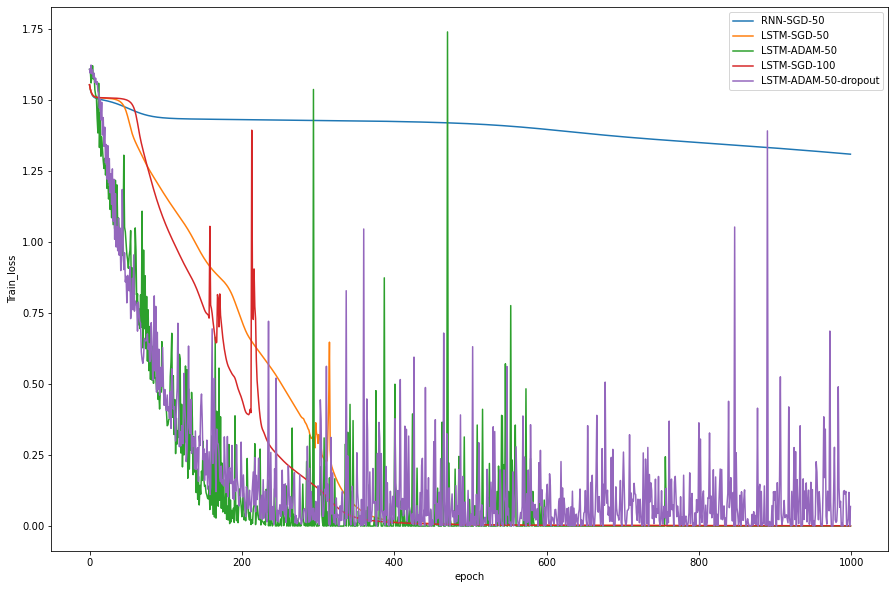

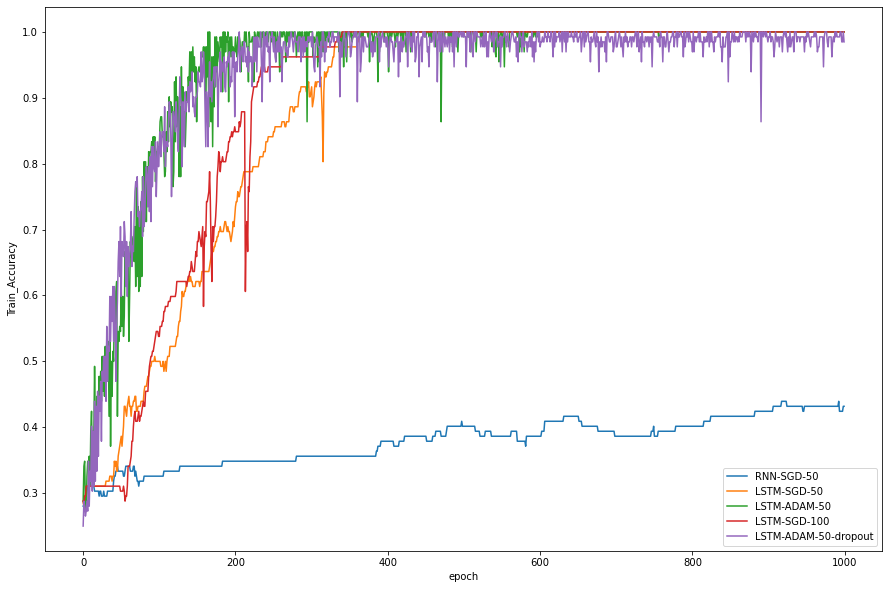

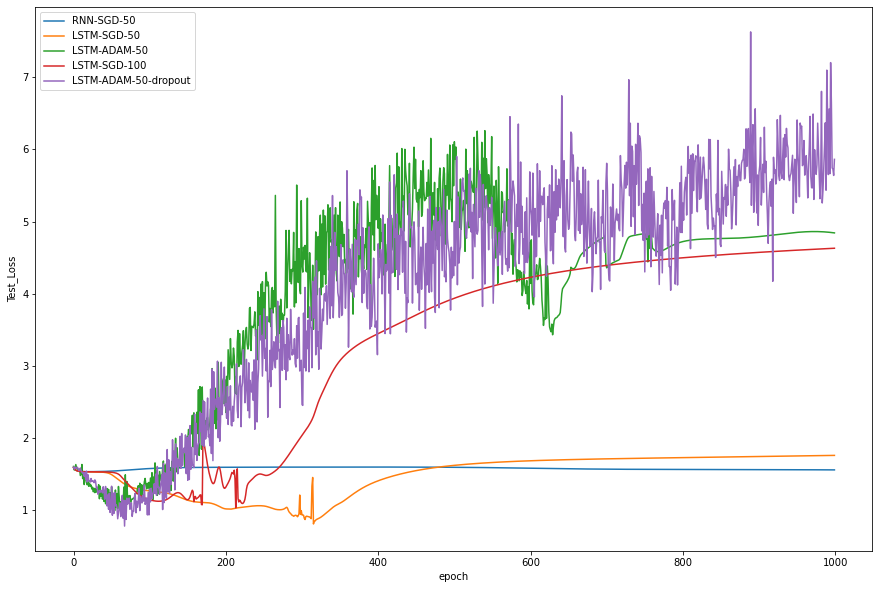

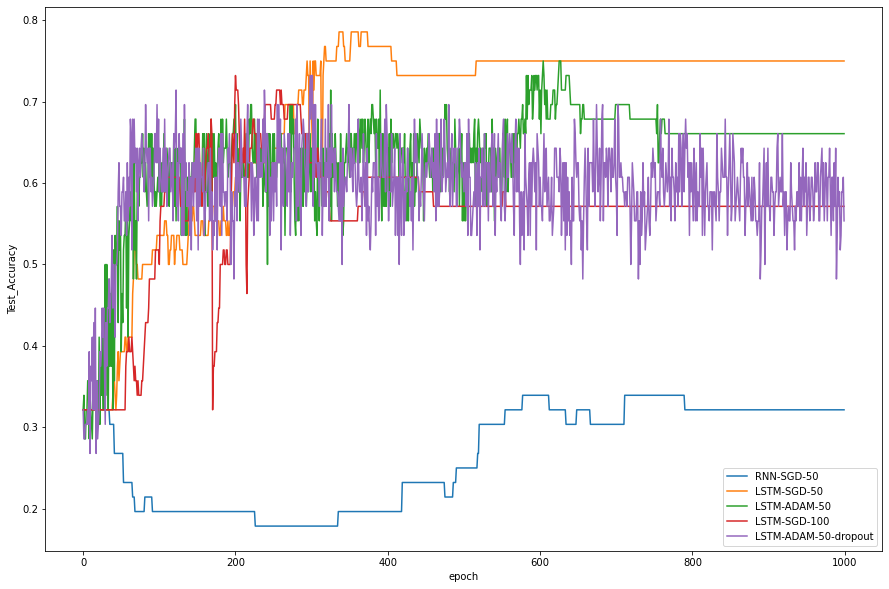

In [331]:
Training_Loss([1,5,6,7,9])
Training_Accuracy([1,5,6,7,9])
Test_Loss([1,5,6,7,9])
Test_Accuracy([1,5,6,7,9])

In [311]:
Test_Result()

Model(a)
  y_pred    y_label     text                                            

X 😞         🍴         I want to eat	                                    

X ⚾         😞         he did not answer	                                

X ⚾         😄         he got a very nice raise	                         

X ❤️        😄         she got me a nice present	                        

O 😄         😄         ha ha ha it was so funny	                         

X ⚾         😄         he is a good friend	                              

O 😞         😞         I am upset	                                       

X 😞         😄         We had such a lovely dinner tonight	              

X ⚾         🍴         where is the food	                                

X 😞         😄         Stop making this joke ha ha ha	                   

O ⚾         ⚾         where is the ball	                                

X 😄         😞         work is hard	                                     

X 😄         😞         This gi

# 5. Describe

Describe the results comparison of optimizers (SGD, ADAM)

RNN structures (RNN, LSTM)

and the length of glove vectors (50d, 100d) 

Describe the difference between Word2Vec and Glove in terms of vector generation

## SGD VS ADAM

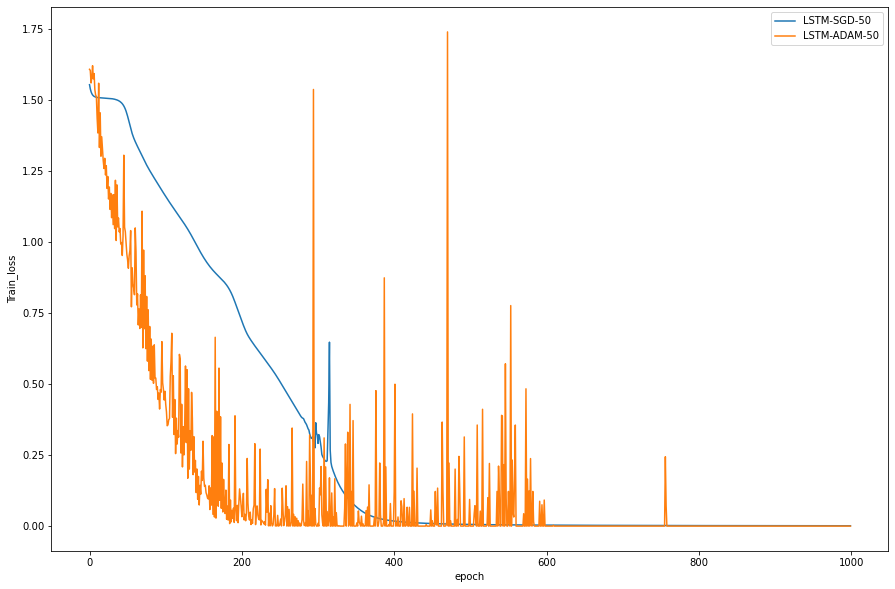

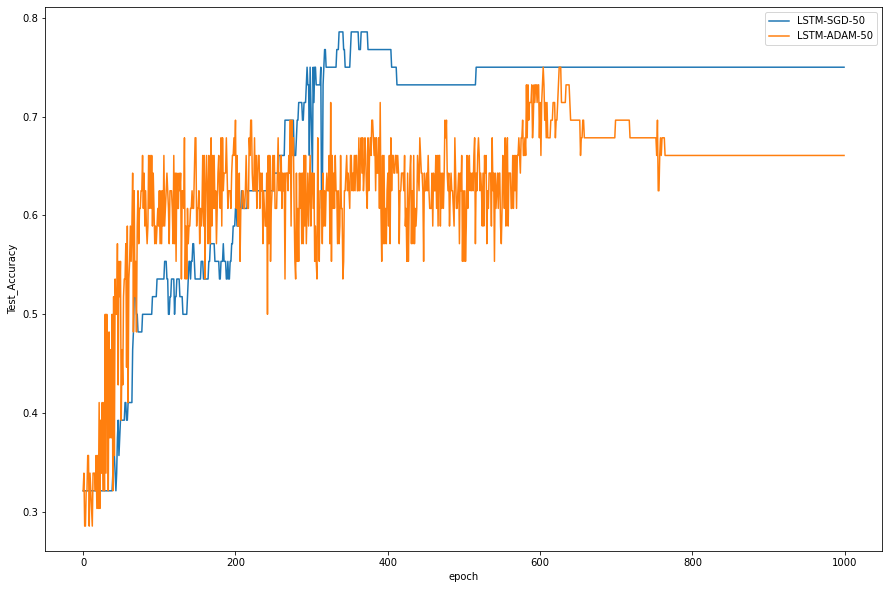

In [330]:
Training_Loss([5,6])
Test_Accuracy([5,6])

Train_Loss를 보면 ADAM 이 SGD에 비해 훨씬 빠른 속도로 하강하며, 하강한 뒤에도 멈추지 않고 계속해서 loss가 튀는 모습을 보임

Test_Accuracy 를 보면 SGD가 ADAM보다 좋은 성능을 보임

## LSTM vs RNN

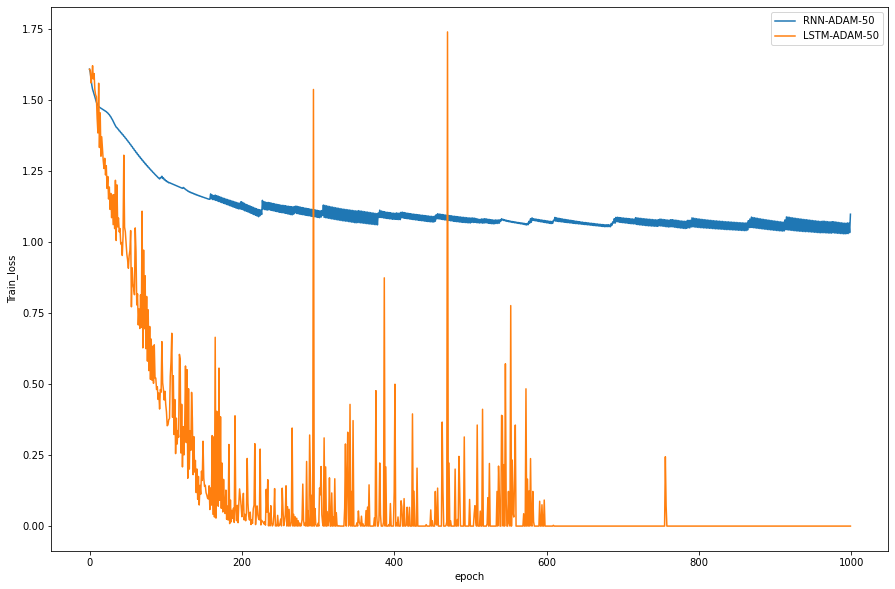

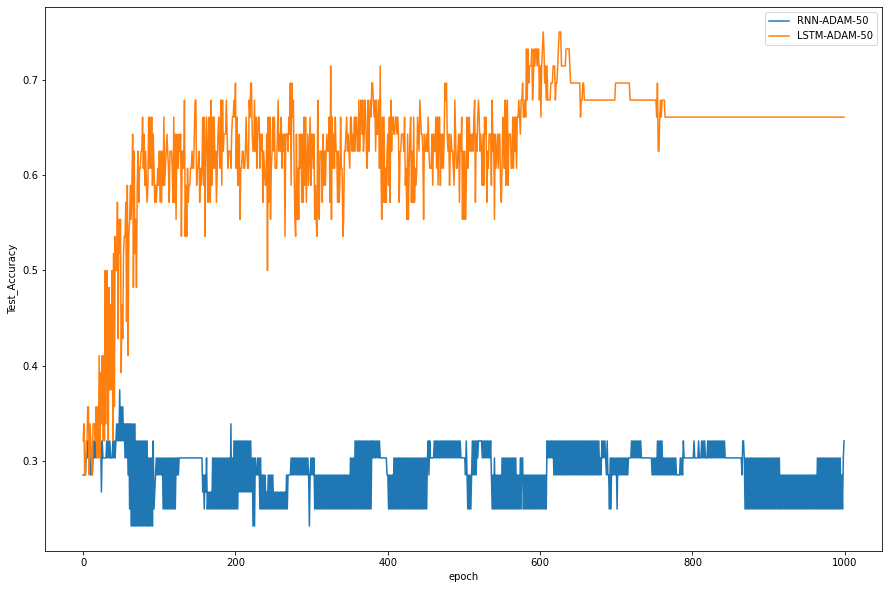

In [329]:
Training_Loss([2,6])
Test_Accuracy([2,6])

LSTM의 정확도가 RNN에 비해 훨씬 높고 loss도 훨씬 낮음

## 50d vs 100d

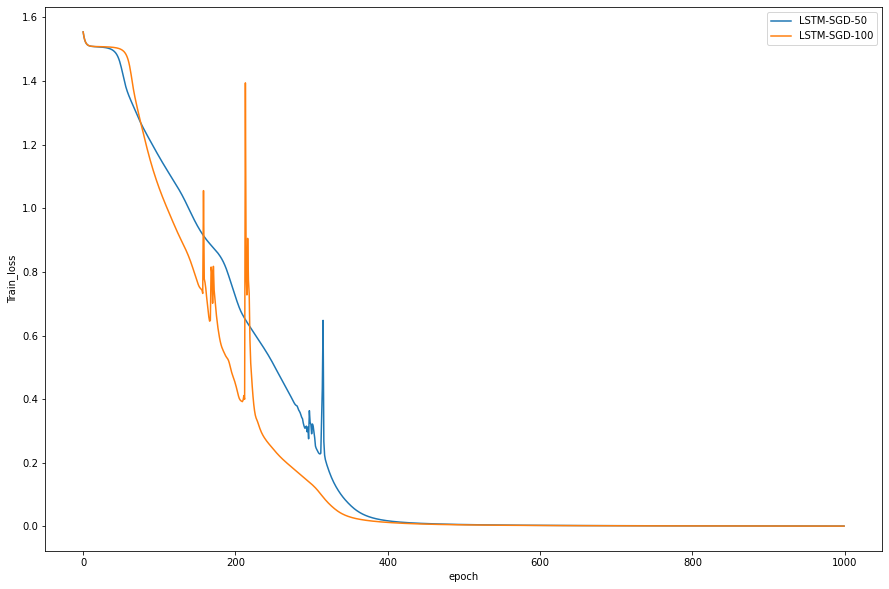

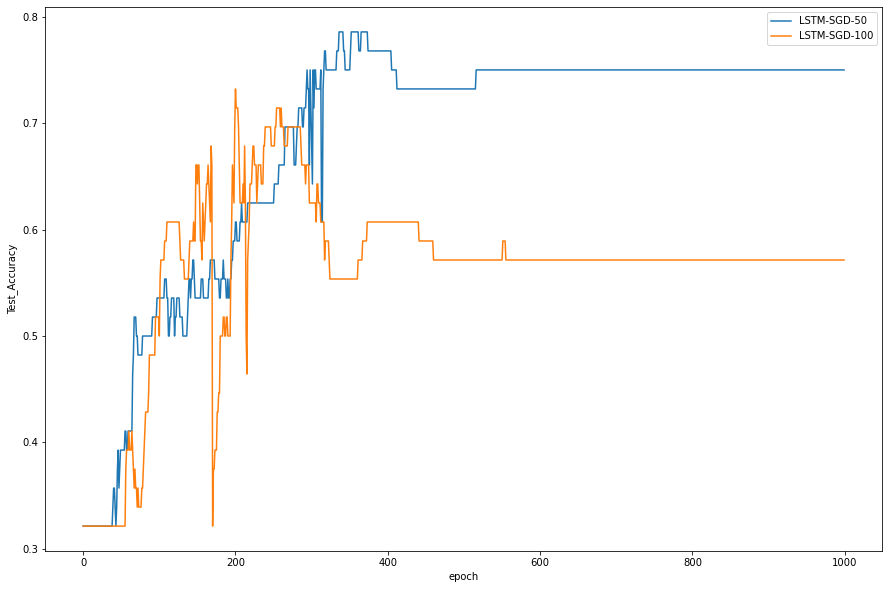

In [333]:
Training_Loss([5,7])
Test_Accuracy([5,7])

100d가 Train_loss는 더 빨리 감소하지만 Test_Accuracy는 좋지 않음

# Word2Vec and Glove

Word2Vec와 Glove 모두 단어 동시 등장 확률을 기반으로 하는데


Word2Vec은 local statistics만 반영함, Glove는 global statistic도 반영